In [ ]:
import mysql.connector as sql
from base_corpus import samples
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

emotions = [' negative', 'confusion', 'modest', 'vulgarity', 'empathy', 'intensity',
            'negative', 'agreeable', 'certanity', 'confident', 'amusement', 'inquisitve',
            ' certainty', 'calm', 'hate', ' instructive', 'desire', 'regrert', 'inquisitive',
            'deire', 'certain', 'emphatic', 'regret', ' challenging', 'positive',
            'inquisitive,', 'admiration', 'instructive', 'love', 'intructive', 'pride',
            'inqusitive', ' accusative', 'anger', 'challenging', ' agreeable', 'ambivalence',
            'anxious', 'joy', 'accusative', 'sarcastic', 'content', 'instrucitve', 'certainty']

X_fear = []
X_other = []
for sample, label in samples:
    if label in ['anger', 'hate', ' negative', 'negative']:
        X_fear.append(sample)
    else:
        X_other.append(sample)

X = X_fear + X_other
y = ['Fear'] * len(X_fear) + ['other'] * len(X_other)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = Pipeline([('vec', CountVectorizer(ngram_range=(1,5))), ('svc', SVC(probability=True))])
pipe.fit(X_train, y_train)
accuracy_score(y_test, pipe.predict(X_test))

In [19]:
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.path as mpltPath
import mysql.connector as sql
import numpy as np
from dateutil import parser
from collections import defaultdict

def gen_state_polys():
        tree = ET.parse('../states.xml')
        root = tree.getroot()
        polys={}
        for child in root:
                if child.tag!='state':
                        continue
                plist=[]
                for p in child:
                        if p.tag!='point':
                                continue
                        plist.append([float(p.attrib['lng']), float(p.attrib['lat'])])
                polys[child.attrib['name'].lower().strip()]=np.array(plist)
        return polys

def state_has_p(state_bounds, lnglat):
        path = mpltPath.Path(state_bounds)
        return path.contains_points(lnglat)

def longlat2state(all_state_bounds,lnglat):
        for s in all_state_bounds:
                if state_has_p(all_state_bounds[s],np.array([lnglat])):
                        return s
        return None


def random_sample():
    db_connection = sql.connect(host='localhost',
            database='gun',
            user='kslote',
            password='password')
    db_cursor = db_connection.cursor()
    db_cursor.execute('SELECT * FROM TWEETS ORDER BY RAND() LIMIT 10000;')
    table_rows = db_cursor.fetchall()
    df = pd.DataFrame(table_rows)
    db_cursor.close()
    return df

def random_sample_days():
    db_connection = sql.connect(host='localhost',
            database='gun',
            user='kslote',
            password='password')
    db_cursor = db_connection.cursor()
    db_cursor.execute('SELECT date FROM TWEETS ORDER BY RAND() LIMIT 10000;')
    table_rows = db_cursor.fetchall()
    df = pd.DataFrame(table_rows)
    db_cursor.close()
    return df

def select_tweet(id):
    db_connection = sql.connect(host='localhost',
            database='gun',
            user='kslote',
            password='password')  
    db_cursor = db_connection.cursor()
    db_cursor.execute('select * from TWEETS where ID=%i limit 1' % id)
    id, username, keywords, date, _, text = db_cursor.fetchall()[0]
    db_cursor.close()
    return date, text

def all_tweets():
    db_connection = sql.connect(host='localhost',
            database='gun',
            user='kslote',
            password='password')
    db_cursor = db_connection.cursor()
    db_cursor.execute('SELECT * FROM TWEETS;')
    table_rows = db_cursor.fetchall()
    df = pd.DataFrame(table_rows)
    db_cursor.close()
    return df

def get_tweets_by_day():
    alls = gen_state_polys()
    A = np.loadtxt("../all_tweets.np")
    tweets_by_day = defaultdict(list)
    for a in A:
        id = int(a[-3])
        lnglat = [a[2], a[1]]
        s = longlat2state(alls, lnglat)
        if s is None:
            continue
        date, tweet = select_tweet(id)
        d = parser.parse(date)
        day_bucket = datetime.datetime(d.year, d.month, d.day)
        tweets_by_day[day_bucket].append(tweet)

['ｖｏｃｅ', 'hospitality', 'horseshort', 'horsfo', 'horticulture', 'horzx20rzm', 'hos7atv73l', 'hosp', 'hospitalization', 'horsepower', 'hospitalizing', 'hosrgcze8b', 'hostel', 'hot4mysoldier', 'hot_messpdx', 'hotdamn', 'horseracing', 'horsenut5', 'horcruxes', 'horrendously']


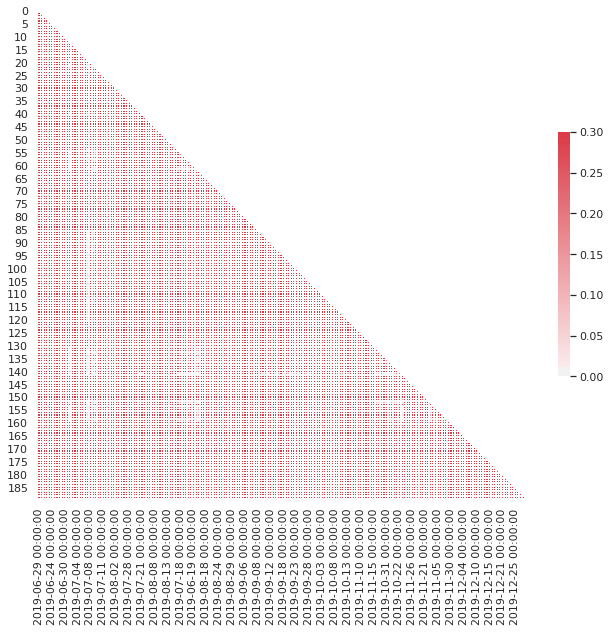

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tweets_by_day = defaultdict(list)
#df = all_tweets()
#df.columns=['id', 'username', 'keyword', 'date', 'label', 'text']
for i, row in df_sample.iterrows():
    d = parser.parse(row.date)
    day_bucket = datetime.datetime(d.year, d.month, d.day)
    tweets_by_day[day_bucket].append(row.text)

samples = list([tweet for tweets in tweets_by_day.values() for tweet in tweets])
vec = TfidfVectorizer()
X = vec.fit_transform(samples)
indices = np.argsort(vec.idf_)[::-1]
features = vec.get_feature_names()
top_n = 20
top_features = [features[i] for i in indices[:top_n]]
print(top_features)
data = {}
for day in tweets_by_day.keys():
    data[str(day)] = np.zeros((1, len(features)))
    for tweet in tweets_by_day[day]:
        matrix = vec.transform([tweet]).todense()
        data[str(day)] += matrix
    data[str(day)] = np.array(data[str(day)].tolist()[0])

sns.set(style="white")

n = len(data.keys())
corr = np.zeros((n, n))
for i, a in enumerate(data.items()):
    _, t1 = a
    for j, b in enumerate(data.items()):
        _, t2 = b
        corr[i, j] = np.correlate(t1, t2)
df = pd.DataFrame(corr, columns=list(data.keys()))
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
df = all_tweets()
df.columns=['id', 'username', 'keyword', 'date', 'label', 'text']
df.head()

,id,username,keyword,date,label,text
0,0,billjryan,"gun control,gun laws,gun violence,mass shootin...",2019-06-29T17:38:30,1,Self Determination In Lands Stolen From The Pa...
1,1,crowned4it,"gun control,gun laws,gun violence,mass shootin...",2019-06-29T17:38:31,1,"Learning is an everyday process, and I'm thank..."
2,2,mdncil991,"gun control,gun laws,gun violence,mass shootin...",2019-06-29T17:38:32,1,RT @ericswalwell: I wear this ribbon for Jaime...
3,3,banished01,"gun control,gun laws,gun violence,mass shootin...",2019-06-29T17:38:33,1,@MeltingInMarana @911_Remembered @Brenda801251...
4,4,11ForTexas,"gun control,gun laws,gun violence,mass shootin...",2019-06-29T17:38:35,1,RT @boxersforlife: Hey @ericswalwell 1. You ca...


In [ ]:
df

In [23]:
df.to_csv('tweets.csv')

In [5]:
import datetime

def by_day(date):
    d = parser.parse(date)
    day = datetime.datetime(d.year, d.month, d.day)
    return day

df['day'] = df['date'].apply(by_day)

In [21]:
day_samples = []
sample_size = 10000
for day in df['day'].unique():
    df_day = df.loc[df['day'] ==  day]
    n = min(sample_size, len(df_day))
    day_samples.append(df_day.sample(n))
df_sample = pd.concat(day_samples)

KeyError: 'day'

In [16]:
df_sample.count()

id          120636
username    120636
keyword     120636
date        120636
label       120636
text        120636
day         120636
dtype: int64